### Q1. Using unsupervised learning to work with galaxies

The following query will select 20k likely galaxies from the SDSS database and return the results of that query into an `astropy Table`.  (For now, if you are not familiar with the SDSS DB schema, don't worry about this query, just know that it returns a bunch of photometric features.)

In [ ]:
#import package and data
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np

GALquery = """SELECT TOP 20000 
         p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
         p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
         p.petroRad_i, p.petroR50_i, p.deVAB_i, p.fracDev_i
         FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
         WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
         AND p.deVAB_i > -999 AND p.petroRad_i > -999 AND p.petroR50_i > -999 AND p.dered_r < 20
           """
SDSSgals = SDSS.query_sql(GALquery)
SDSSgals

### 1a - Visualize the dataset in g-i (y) vs u-g (x) and all the features (11 pts). 

The bluest galaxies are star-forming galaxies at low redshift 𝑧. The "tight" cluster of red galaxies are passive galaxies at low-𝑧. Finally the diffuse cloud at 𝑔−𝑖≈3 are high-𝑧 luminous red galaxies (LRGs) that were targeted for BAO measurements. These sources have a wide range of 𝑢−𝑔 colors because they essentially are not detected in the 𝑢 band as this is blueward of the Lyman break.

Plot and examine each of the features in this data set using seaborn's `PairGrid`. Overlay a histogram and kernel density distribution (KDE) on each 1D and 2D plot. You should be able to roughly see the different groups of galaxies, but how to separate them?

In [5]:
#change data to dataframe
import pandas as pd
data = SDSSgals.to_pandas()

In [8]:
#filtering the data
import scipy.stats
for i in list(data):
    MAD = scipy.stats.median_abs_deviation(x = data[i],scale = 'normal',nan_policy = 'omit')
    median = np.nanmedian(data[i])
    data = data[(data[i]<median+10*MAD)&(data[i]>median-10*MAD)]

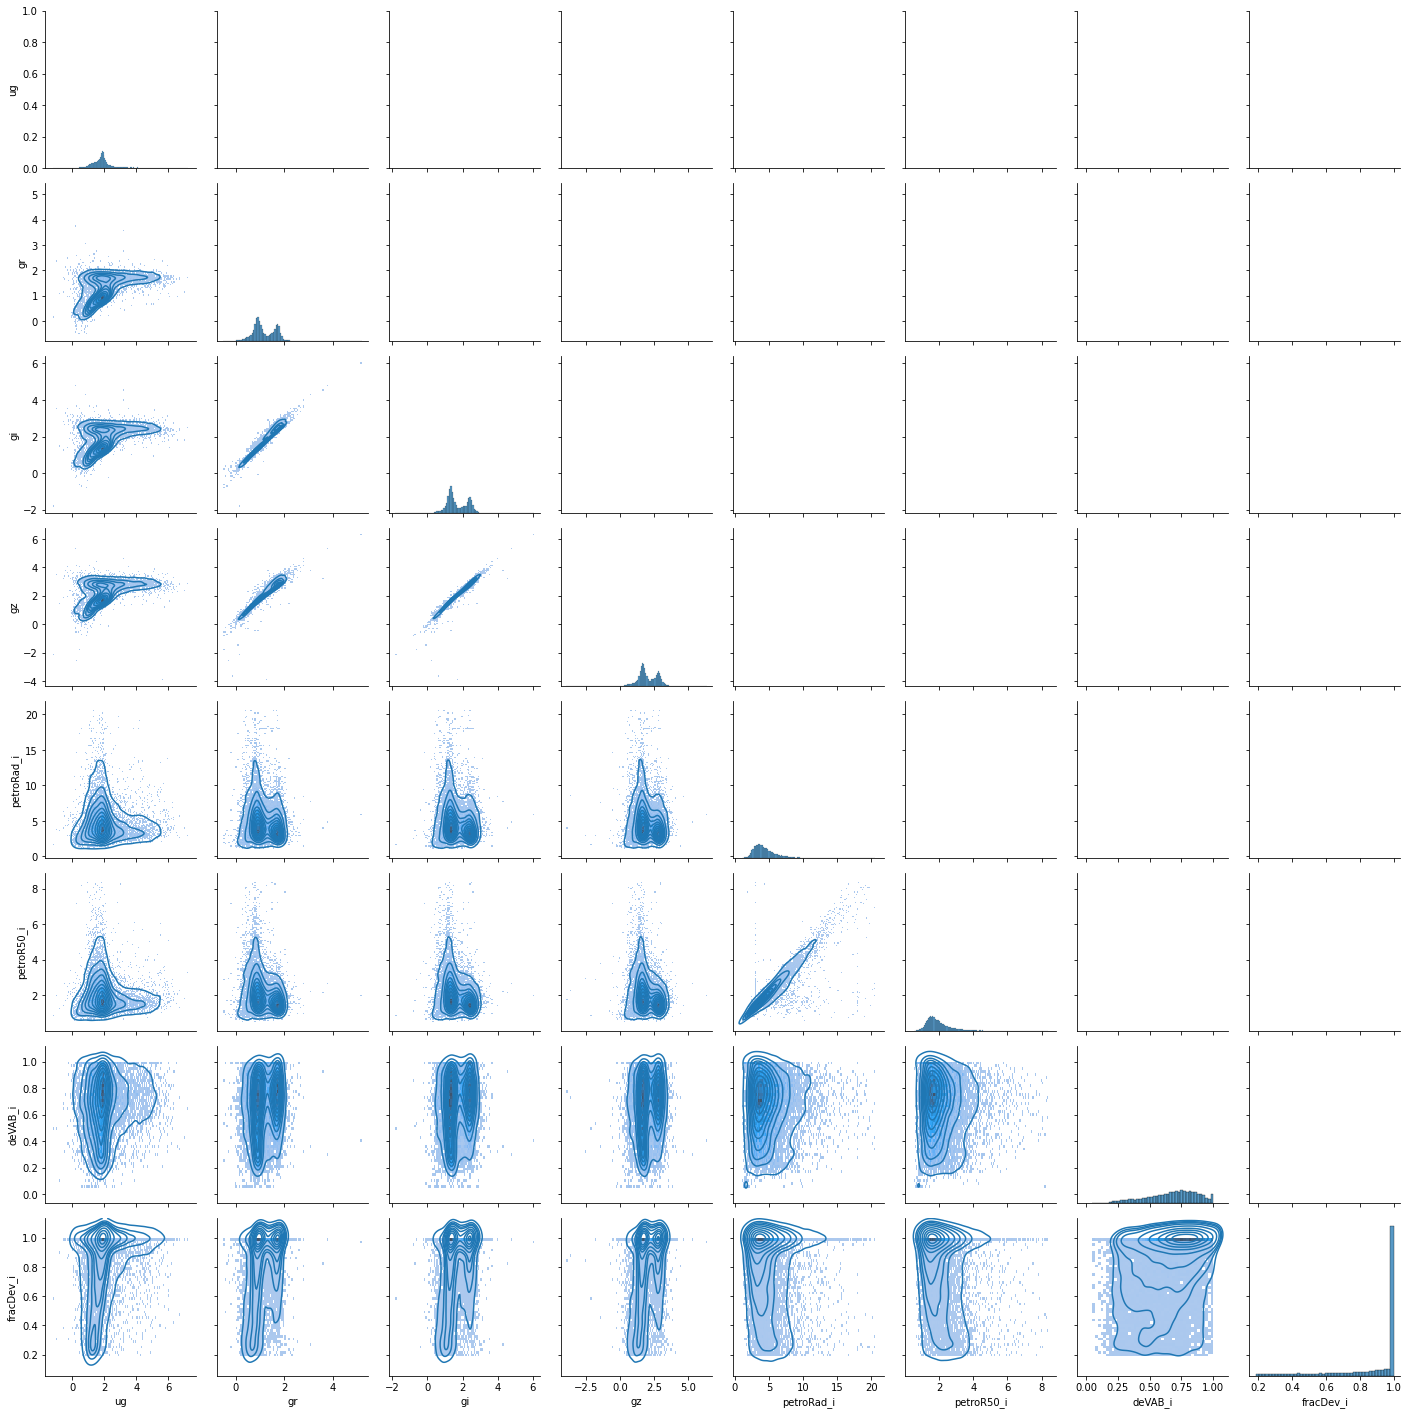

In [13]:
#plot
g = sns.PairGrid(data)
g.map_diag(sns.histplot)
g.map_lower(sns.histplot)
g.map_lower(sns.kdeplot)

### 1b - Separating the galaxy types (11 pts) 

Using K-means from `sklearn` with n=3, separate the three clusters of galaxies. Initial guesses, hyper-paramter tuning, dimensionality reduction etc are your choices. What's important is to be able to justify them. To the referee, to me, to yourself. We'll do that in the next part. 

In [10]:
#calculate kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

z = StandardScaler()
Xt = z.fit_transform(data)
kmeans = KMeans(n_clusters=3,n_init='auto')
kmeans.fit(Xt)
labels = kmeans.labels_

KMeans(n_clusters=3, n_init='auto')

### 1c - Working with the distributions (11 pts)
Repeat 1a, but using the results of K-means in 1b to create separately colored distributions for your different classes of galaxies. Use the KDE to provide the mean values of each feature and their standard deviation (hint - these are integrals), and compare them to the sample means and standard deviations. 

In [14]:
#add labels to data
data['label'] = labels

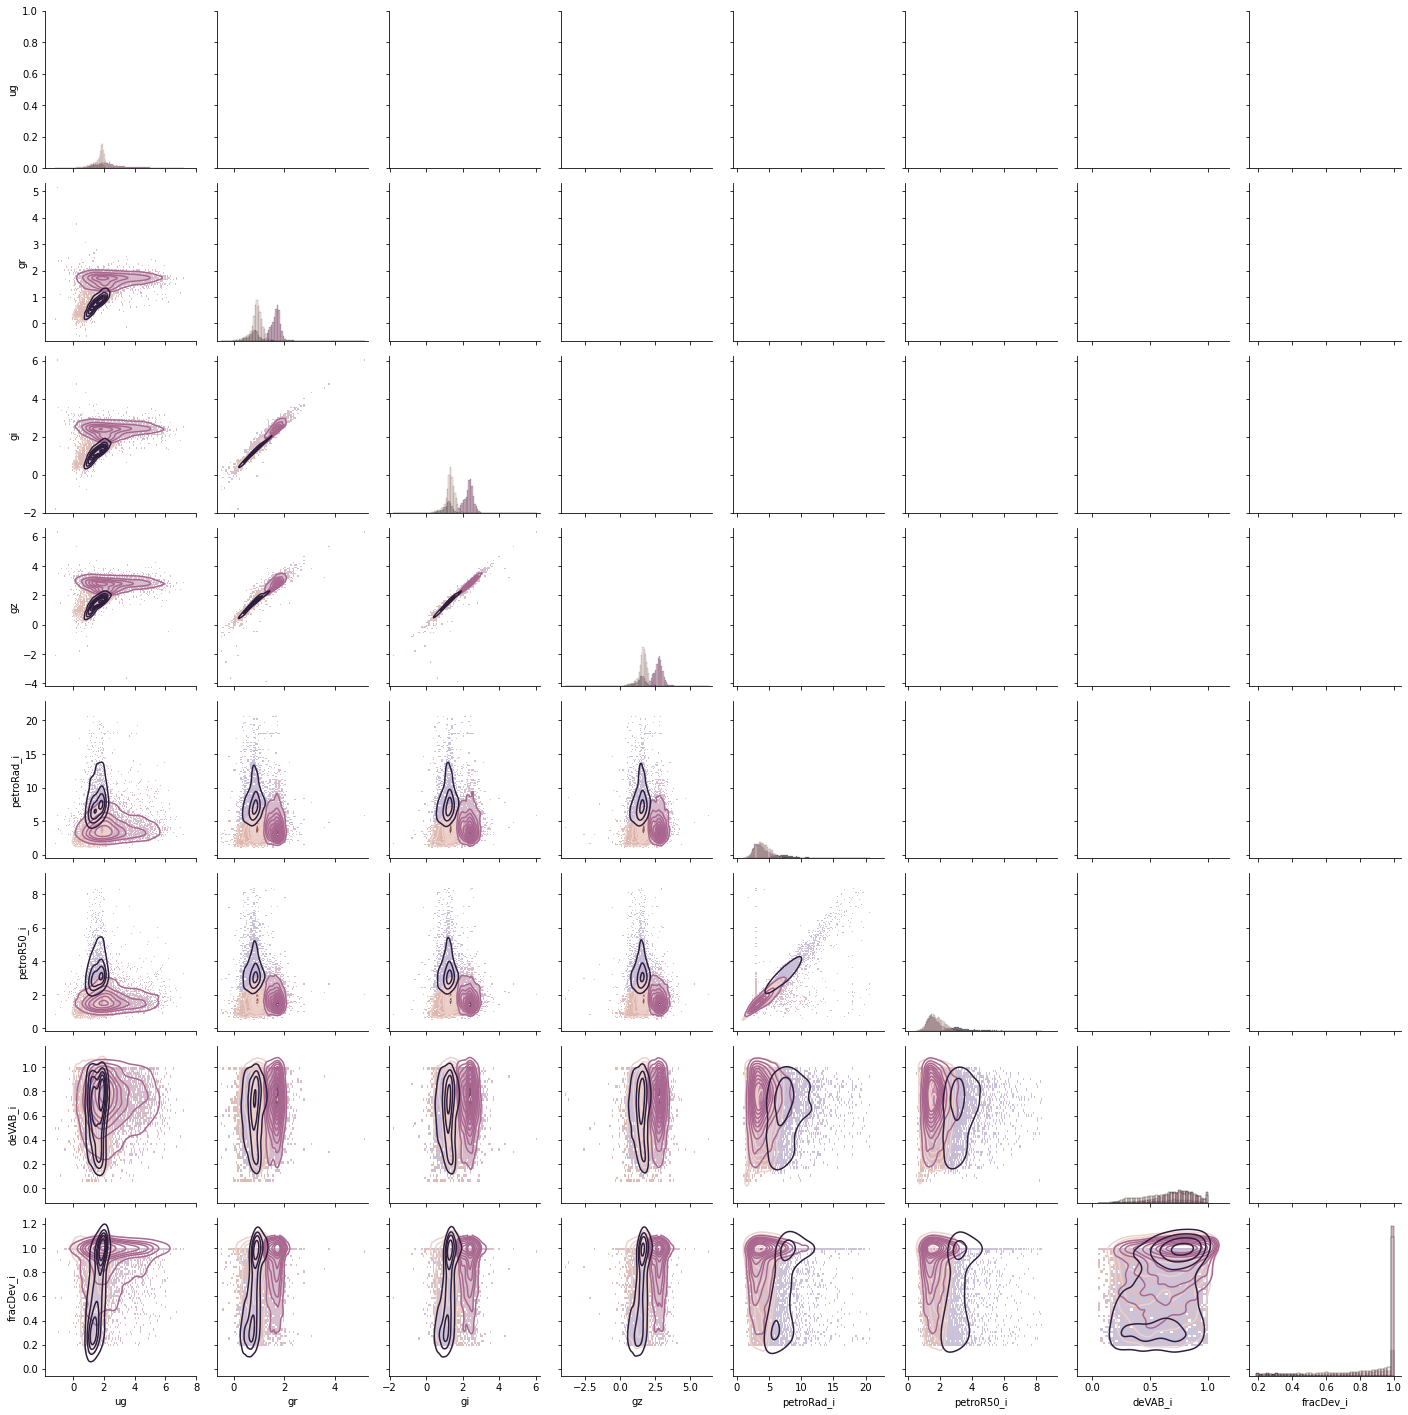

In [16]:
#plot
g = sns.PairGrid(data,hue = 'label',palette = 'tab10',diag_sharey = False)
g.map_diag(sns.histplot)
g.map_lower(sns.histplot)
g.map_lower(sns.kdeplot)

In [38]:
#calculate kde means and variance
from sklearn.neighbors import KernelDensity

print('            mean value, variance')
for i in range(8):
    for j in range(3):
        data_slice = np.array(data[data['label']==j][data.columns[i]])
        kde = KernelDensity(bandwidth=0.5, kernel='gaussian').fit(data_slice[:,None])
        pdf = lambda data_slice : np.exp(kde.score_samples([[data_slice]]))[0]
        mean_integration = quad(lambda data_slice: data_slice * pdf(data_slice), a=-np.inf, b=np.inf)[0]
        variance_integration = quad(lambda data_slice: (data_slice ** 2) * pdf(data_slice), a=-np.inf, b=np.inf)[0] - mean_integration ** 2
        print('%s, label%d: %f05, %f05'%(data.columns[i],j,mean_integration,variance_integration))
    data_slice = np.array(data[data.columns[i]])
    kde = KernelDensity(bandwidth=0.5, kernel='gaussian').fit(data_slice[:,None])
    pdf = lambda data_slice : np.exp(kde.score_samples([[data_slice]]))[0]
    mean_integration = quad(lambda data_slice: data_slice * pdf(data_slice), a=-np.inf, b=np.inf)[0]
    variance_integration = quad(lambda data_slice: (data_slice ** 2) * pdf(data_slice), a=-np.inf, b=np.inf)[0] - mean_integration ** 2
    print('%s, all   : %f05, %f05'%(data.columns[i],mean_integration,variance_integration))

            mean value, variance
ug, label0: 1.67739205, 0.45425605
ug, label1: 2.45178605, 1.58492705
ug, label2: 1.62144505, 0.45873105
ug, all   : 1.96940505, 1.04024305
gr, label0: 0.89509105, 0.30059805
gr, label1: 1.65845005, 0.28625705
gr, label2: 0.79909405, 0.30834205
gr, all   : 1.17716205, 0.44357105
gi, label0: 1.31537105, 0.33238405
gi, label1: 2.35296705, 0.32212505
gi, label2: 1.19977305, 0.35309005
gi, all   : 1.70088305, 0.60159105
gz, label0: 1.62159005, 0.38158605
gz, label1: 2.75324705, 0.34365205
gz, label2: 1.47895505, 0.42611805
gz, all   : 2.03970605, 0.69725905
petroRad_i, label0: 4.03439505, 1.62032105
petroRad_i, label1: 4.08894305, 2.64780405
petroRad_i, label2: 8.33941705, 8.16242005
petroRad_i, all   : 4.66473005, 5.17053905
petroR50_i, label0: 1.77313505, 0.46114805
petroR50_i, label1: 1.70195205, 0.47949005
petroR50_i, label2: 3.52540905, 1.40878605
petroR50_i, all   : 1.99353105, 0.99024605
deVAB_i, label0: 0.64634205, 0.29399205
deVAB_i, label1: 0.7189

### Q2. Gaussian Processes + Emcee

There are many sources with periodic light curves that are not strictly sinusoidal. Thus, the use of the cosine kernel (on its own) may not be sufficient to model the signal. The quasi-periodic kernel: 

$$K_{ij} = k(x_i - x_j) = A \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

is useful for non-sinusoidal signals. It is implemented in the `george` package. Note that the parameters in the kernel aren't the only parameters you might need... look back on your previous homework assignments and think about what I'm glossing over here. 

I've given you an example light curve file with a decidedly non-sinusoidal, periodic signal from the ASAS-SN project from our colleagues at OSU. 

### 2a - Implement the model  (11 pts)

Examine this data, filter it as you see fit (I've included the file header in full - I'd pick one aperture, and look at the grades and notes about separate datasets). You can make tradeoffs here - more data that is potentially messier, vs less data so weaker constraints, but cleaner. Pick something that you can justify (and if you're struggling at 2c, examine this choice before twiddling with emcee). 

Write down a model for it with the likelihood function, an appropriate prior and posterior.

You may wish to look at the `george` documentation again, particularly how some parameters are better log transformed if the expectation is that they are positive real values. 

https://george.readthedocs.io/en/latest/tutorials/model/

In [1]:
#read in data
skiprows = []
with open('asas_data.dat') as f:
    for index, line in enumerate(f):
        if line[0] == '#':
            skiprows.append(index)

In [3]:
#read in the data
import csv
df = pd.read_csv('asas_data.dat',skiprows= skiprows,sep = '\s+',names = ['HJD','MAG_1','MAG_0','MAG_2','MAG_3','MAG_4','MER_1','MER_0','MER_2','MER_3','MER_4','GRADE','FRAME'])
df = df[df['GRADE'] == 'A']
df = df[['HJD','MAG_2','MER_2','FRAME']]

In [117]:
#define the kernel
import george
from george import kernels

def kernel(A, gamma,logP):
    return A*kernels.ExpSine2Kernel(gamma=gamma, log_period=logP)

In [118]:
#define the model
from george.modeling import Model
class kepler_mean_model(Model):
    parameter_names = ("m")
    def get_value(self, t):
        
        t = t.flatten()
        # the baseline model is the mean m
        mean_model = np.repeat(self.m, len(t))
        
        return mean_model  

In [119]:
# so finally our prior is:
def log_prior(p):
    global bounds
    logprior = np.zeros(4)
    for j in range(4):
        limit = bounds[j]
        if (p[j] < limit[0]) or (p[j] > limit[1]):
            return -np.inf
        else:
            logprior[j] = -0.5*((p[j]-guess[j])/(5.*sigma[j]))**2
        
    return logprior.sum()

In [120]:
# setup the posterior
model = george.GP(mean=kepler_mean_model(m), kernel=kernel(A, gamma, logP))
t = df['HJD']
y = df['MAG_2']
yerr = df['MER_2']
model.compute(t, yerr)

In [32]:
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + log_prior(p)

### 2b - Initial Guesses (11 pts)

Make some initial guess for the parameters. For the period, use Lomb-Scargle to find the top three periods for this light curve. Initialize 1/3rd of the walkers to each of the top three periods

Do the burn in with `emcee` - a 100 walkers and a 1000 steps should be plenty - you should find that the walkers have migrated away from the starting guess. Plot the chains. 

Make a plot of the log of the Posterior vs the log of the Period - select the periods with the highest log Posterior and change the initial guess for the Period of all the walkers to be in a small region around the Period with the highest log Posterior. 

In [8]:
from astropy.timeseries import LombScargle

frequency, power = LombScargle(df['HJD'],df['MAG_2']).autopower()

In [9]:
#find the top three frequencies/periods
from astropy.table import Table
t = Table([frequency,power], names=('frequency','power'))
t.sort('power')
t

<Table length=12363>
     frequency              power         
      float64              float64        
------------------- ----------------------
 0.5037325969908719 2.4631112656143217e-07
 0.3716517450982434 2.9487078640715845e-07
 0.5636480614857833  4.079718513160347e-07
 0.3872370430488428  5.702789290332967e-07
0.10918805042822669  9.216444284489256e-07
 0.6415745512387804  1.022457100833818e-06
                ...                    ...
0.35655159260914127    0.33006957215464666
0.35667287897451555    0.34664445734494675
0.35394393575359345     0.3470675646744568
 0.6460015035749429    0.35557828847442935
 0.3566122357918284    0.38137508718144136
 0.6461227899403172      0.419427223687254
 0.6460621467576301    0.43323931816706496

In [40]:
model.get_parameter_dict()

OrderedDict([('mean:m', 23.304477364053678),
             ('kernel:k1:log_constant', -0.30542014321123645),
             ('kernel:k2:gamma', 8.507961541740144),
             ('kernel:k2:log_period', -0.2351615975827891)])

In [11]:
import numpy as np

In [12]:
# First we'll do initial guesses:

# means and offsets are easy
m = np.mean(df['MAG_2'])

# just use the stddev for the first cycle to get some scale for the amplitude
A = df['MAG_2'].std() 

# gamma is modulating the periodic variation - we'll just set it to 1.
gamma= 1.

# squiggles are roughly every 15 days from the plot
logP = np.log(2.)

# long-period variations are on the scale of the Kepler cycles - from cycle 8/9, this is maybe 150 days
#lam  = 150

p0 = [m, A, gamma, logP]

In [13]:
guess = [m, np.log(A), gamma, logP]

# we can do a tophat on each parameter minimally
bounds = []

# we already have a scale of variation for the mean and offsets
bounds.append((m - 2*A, m+2*A))
# we have some additional constraints, but we'll define this in the log prior function

# don't allow the amplitude to go to 0 - the scale can't be too far off from our initial guess
bounds.append((np.log(0.5*A), np.log(1000*A)))

# no good idea for gamma, but probably shouldn't allow it to be 0
bounds.append((0.1, 100.))

# logP - from the plot, 15 is pretty reasonable - it's not 10 and it's not 20, so lets use those as bounds
bounds.append((np.log(1), np.log(5)))

# lam - we know that this is longer than the periodic variations 
#bounds.append((np.log(5.), np.log(1000.)))



# we also need to initialize the walkers for emcee so we need some scale parameter
sigma = []

# mean and offset is again easy
sigma.append(10.)

# A
sigma.append(np.log(5.))

# gamma
sigma.append(0.5)

# logP
sigma.append(np.log(2.))

# lambda
#sigma.append(np.log(20.))

In [34]:
import scipy.stats as st
import emcee


# setup the sampler
nwalkers, ndim = 100, len(model)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# initalize walker positions
p0 = st.norm.rvs(loc=guess, scale=sigma, size=(nwalkers,ndim))
p0[0:33,3] = np.log(1/0.6460621467576301)
p0[33:66,3] = np.log(1/0.6461227899403172)
p0[66:99,3] = np.log(1/0.3566122357918284)



# number of samples
nsamp = 1000
_ = sampler.run_mcmc(p0, nsamp, progress=True)

100%|███████████████████████████████████████| 1000/1000 [49:10<00:00,  2.95s/it]


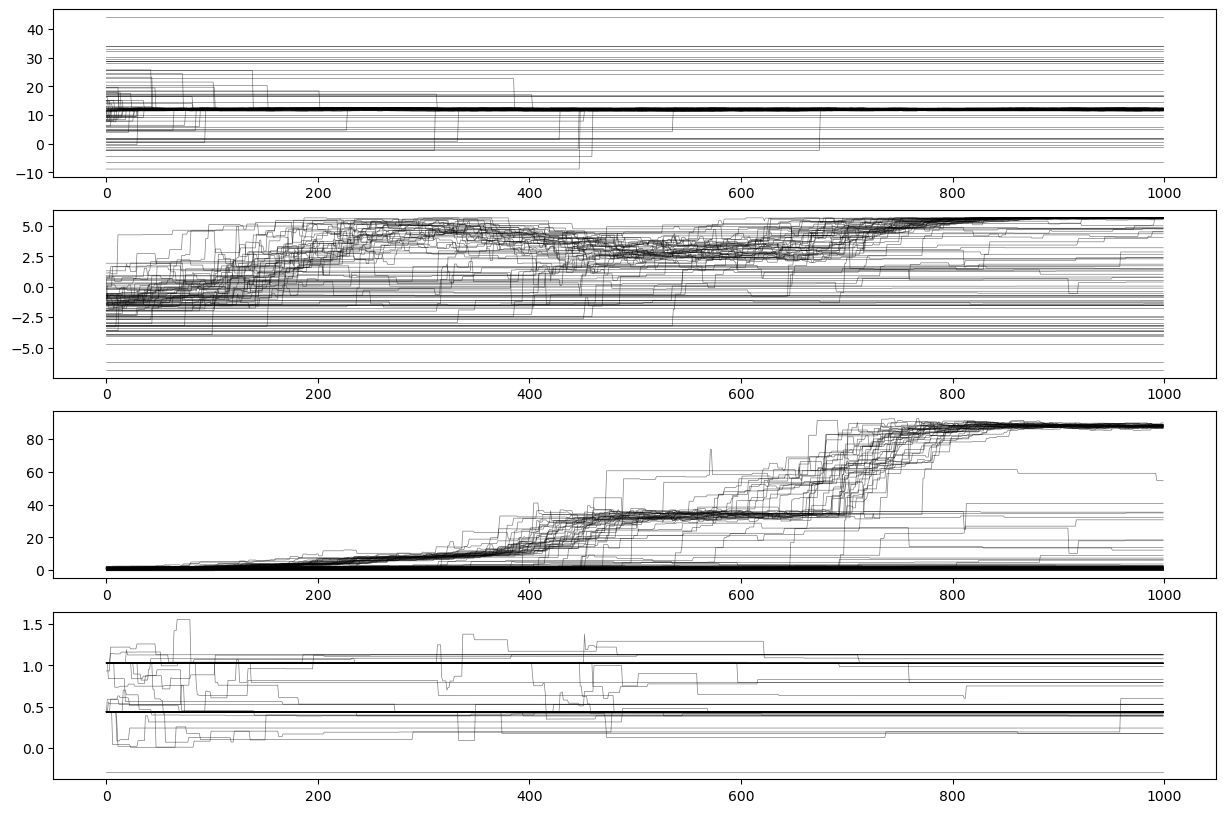

In [38]:
#plot the chains
fig, axes = plt.subplots(4,1,figsize=(15,10))
for i in range(4):
    for j in range(nwalkers):
        axes[i].plot(sampler.chain[j][:, i], color="black", alpha = 0.5, lw = 0.5)
    #ax.set_ylabel(labels[i])
    #ax.set_xlim(0, nburn+)

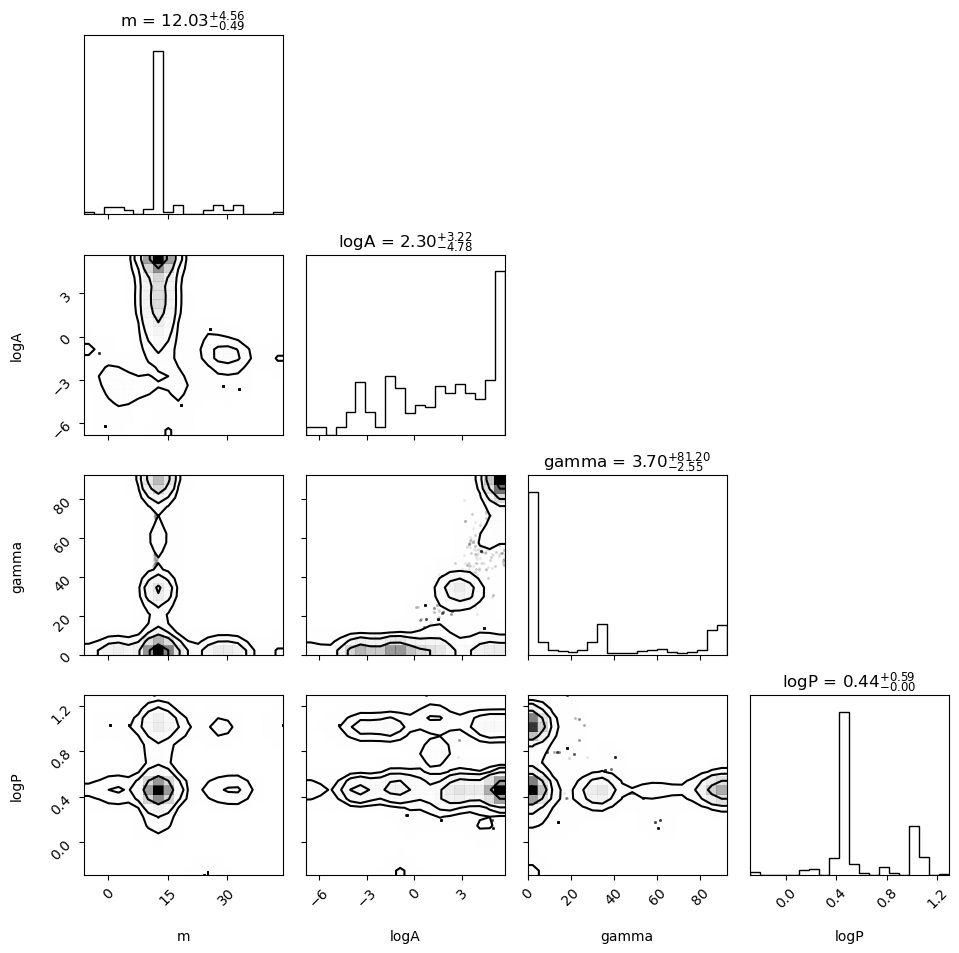

In [39]:
thin = 10
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
sample = sample[::thin,:]
import corner
labels = ['m','logA','gamma','logP']

fig3 = corner.corner(sample,labels=labels, plot_contours=True, show_titles=True, smooth=1)
fig3.tight_layout()
plt.show()


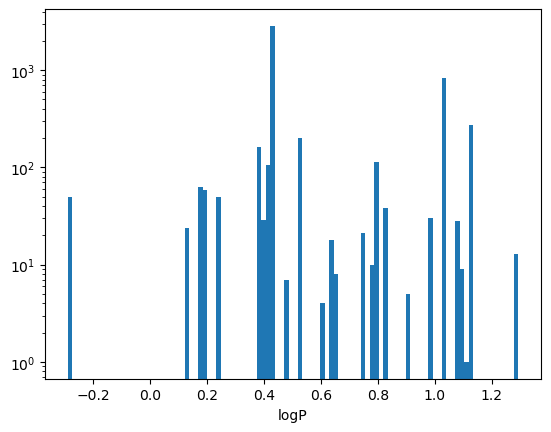

In [48]:
#plot the log of the poesterior vs the log of the period
plt.hist(sample[:,3], bins=100)
plt.yscale('log')
plt.xlabel('logP')
plt.show()

### 2c - Infer the model parameters (11 pts)

Plot the chains, the corner plot, the folded lightcurve, the Gaussian process model given the median parameters, 10 other draws from the model and the uncertainty about the model. 

In [49]:
#rerun the mcmc
#initial guess
m = 12
A = 1
gamma= 8.5
logP = 0.44
p0 = [m, A, gamma, logP]

In [50]:
guess = [m, A, gamma, logP]

bounds = []

bounds.append((m - 2*A, m+2*A))
bounds.append((0.1, 10))
bounds.append((0.1, 1000))
bounds.append((0.35, 0.55))

sigma = []
sigma.append(3)
sigma.append(1)
sigma.append(10)
sigma.append(0.1)

In [51]:
import scipy.stats as st
import emcee


# setup the sampler
nwalkers, ndim = 100, len(model)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# initalize walker positions
p0 = st.norm.rvs(loc=guess, scale=sigma, size=(nwalkers,ndim))

# number of samples
nsamp = 1000
_ = sampler.run_mcmc(p0, nsamp, progress=True)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Users/yujiewan/miniconda3/envs/fds/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 1000/1000 [50:47<00:00,  3.05s/it]


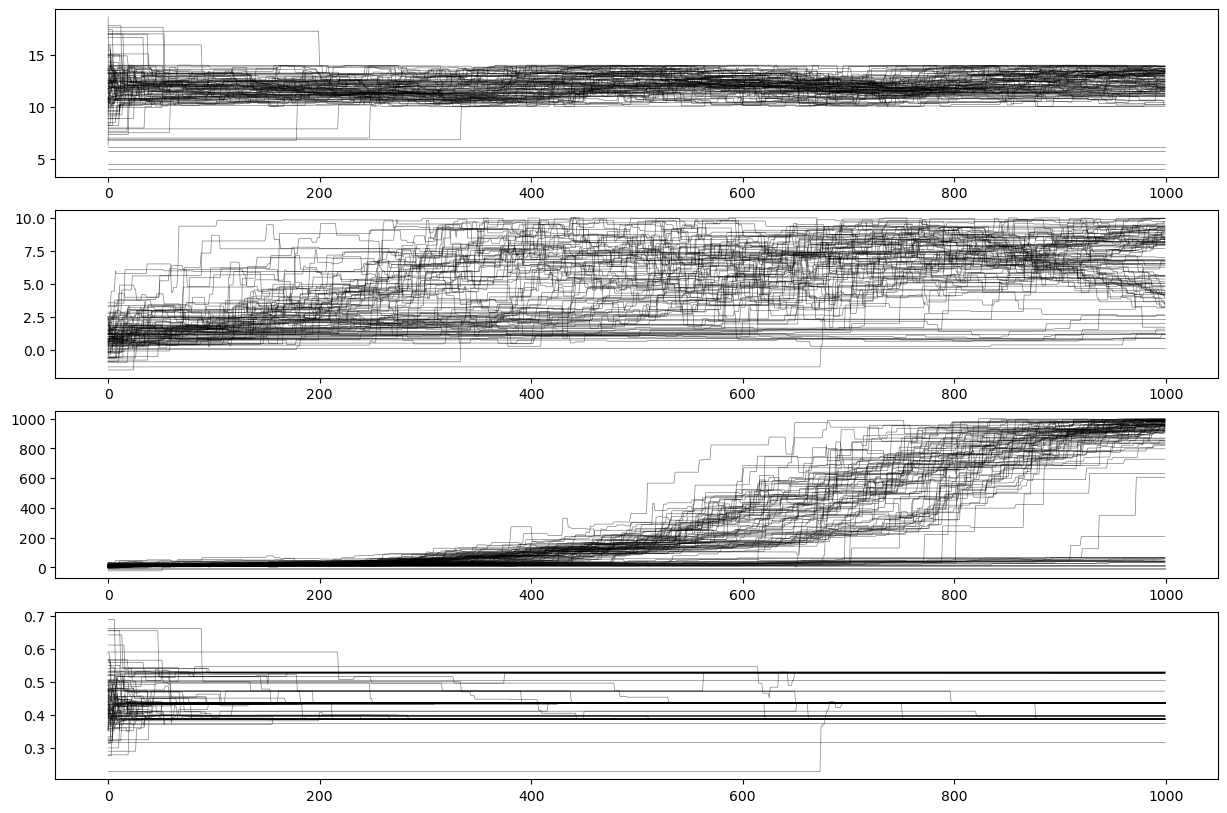

In [52]:
#plot the chains
fig, axes = plt.subplots(4,1,figsize=(15,10))
for i in range(4):
    for j in range(nwalkers):
        axes[i].plot(sampler.chain[j][:, i], color="black", alpha = 0.5, lw = 0.5)
    #ax.set_ylabel(labels[i])
    #ax.set_xlim(0, nburn+)

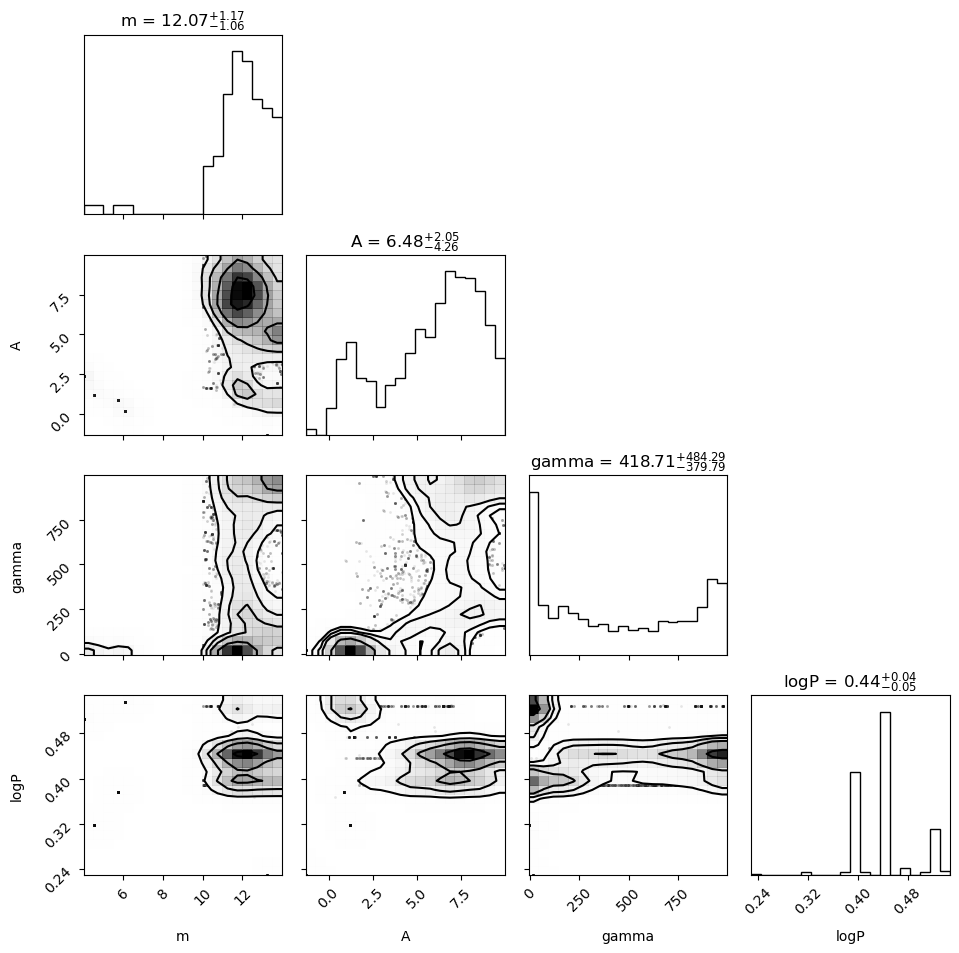

In [55]:
thin = 5
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
sample = sample[::thin,:]
import corner
labels = ['m','A','gamma','logP']

fig3 = corner.corner(sample,labels=labels, plot_contours=True, show_titles=True, smooth=1)
fig3.tight_layout()
plt.show()


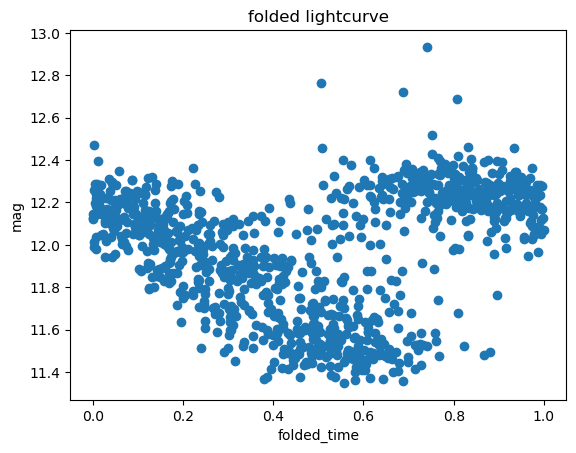

In [107]:
time = df['HJD']
time_min = min(df['HJD'])
flux = df['MAG_2']
best_period = np.exp(np.median(sample[:,3]))
time_fold = ((time-time_min)%best_period)/best_period
plt.scatter(time_fold,flux)
plt.xlabel('folded_time')
plt.ylabel('mag')
plt.title('folded lightcurve')
plt.show()

In [142]:
p = np.zeros(4)
for i in range(4):   
    p[i] = np.mean(sample[:,i])

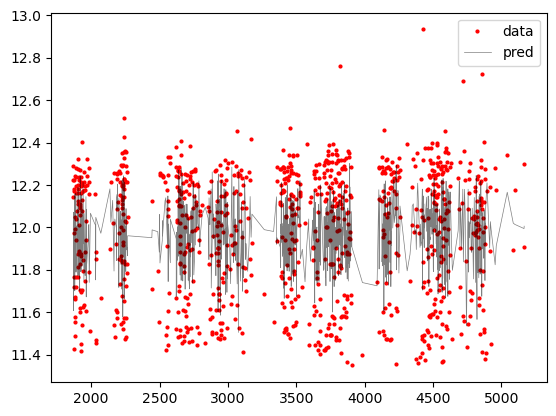

In [144]:
model.set_parameter_vector(p)
pred = model.predict(df['MAG_2'], df['HJD'], return_cov=False)
plt.plot(df['HJD'], df['MAG_2'],'r.',ms = 4,label = 'data')
plt.plot(np.sort(df['HJD']), pred, 'k', linewidth = 0.5, alpha=0.5,label = 'pred')
plt.legend()
plt.show()

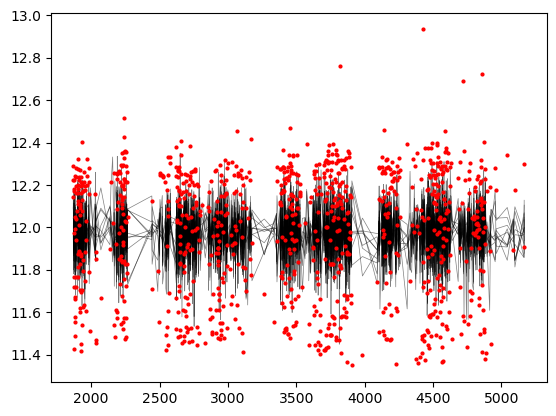

In [147]:
sampler_chain = sampler.get_chain(flat=True)
for i in np.random.randint(0, len(sampler_chain), 10):
    p = sampler_chain[i]
    p[3] = np.exp(sampler_chain[i][3])
    model.set_parameter_vector(p)
    pred = model.predict(df['MAG_2'], df['HJD'], return_cov=False)
    plt.plot(np.sort(df['HJD']), pred, 'k', linewidth = 0.5, alpha=0.5,label = 'pred')
plt.plot(df['HJD'], df['MAG_2'],'r.',ms = 4,label = 'data')

### Q3: PyMC (yes, that thing), hierarchical mixture models, and the mass-radius relation for small exoplanets

The mass-radius relation is a relationship between the radius $R$ of an exoplanet and its mass $M$. We usually call planets smaller than the Neptune size $(R < 4 R_{\oplus})$ small planets. In the Solar System, we don't have any planets between the Earth and Neptune sizes ($ 1-4 R_{\oplus}$), whereas in extrasolar systems, plenty of planets with radii in the range are observed. Thus, it's extremely intriguing to study the compositions of these planets and understand why we don't have one in the Solar System.

In this problem, you will work on one of the papers that one of our colloquium speakers brought up (this is why you should go to colloquium btw, because it'd have totally helped with this final exam to know the answer) - the mass-radius relation for small exoplanets around M-dwarfs. 

The paper is by [Luque et al., Science 377, 1211 (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220903871L/abstract). We will reproduce some of their results using the PyMC.

In [1]:
## Download the dataset from Luque et al. 2022
import pandas as pd
data = pd.read_csv("https://carmenes.caha.es/ext/tmp/TMP.csv")
data.head()

ID  ID_Star      Star          AltName       Karmn     RA_J2000  \
0   1        1   GJ 3053         LHS 1140  J00449-152  00:44:59.33   
1   2        1   GJ 3053         LHS 1140  J00449-152  00:44:59.33   
2   3        2  TOI-1468  LSPM J0106+1913  J01066+192  01:06:36.98   
3   4        2  TOI-1468  LSPM J0106+1913  J01066+192  01:06:36.98   
4   5        3   GJ 3090          TOI-177         NaN  01:21:45.39   

      DE_J2000     SpT  SpTnum    d_pc  ...  eurho_gcm-3  edrho_gcm-3  Teq_K  \
0  -15:16:17.5  M4.5 V     4.5  14.964  ...         0.84         0.80  378.9   
1  -15:16:17.5  M4.5 V     4.5  14.964  ...         0.81         0.74  708.9   
2  +19:13:33.2    M3 V     3.0  24.721  ...         1.05         0.92  682.2   
3  +19:13:33.2    M3 V     3.0  24.721  ...         0.21         0.19  337.5   
4  -46:42:51.8    M2 V     2.0  22.454  ...         0.52         0.45  693.0   

   euTeq_K  edTeq_K     TSM   ESM  Method  DiscoveryRef       ParameterRef  
0      4.3      4.2    8.88  0.19      RV         Dit17  Dit17 Men19 Lil20  
1      8.0      7.8   25.90  3.45      RV         Dit17  Dit17 Men19 Lil20  
2      7.4      6.9    9.00  6.30      RV         Cha22              Cha22  
3      3.7      3.4   59.00   NaN      RV         Cha22              Cha22  
4     18.0     18.0  221.00   NaN      RV        Alm22a             Alm22a  

[5 rows x 44 columns]

In [2]:
## Lets extract mass and radius and their uncertainties from the data; both M and R are in Earth units 
M = data.M_Mterra
R = data.R_Rterra

err_M = (data.edM_Mterra+data.euM_Mterra)/2  # Assume the + and - errors on M and R are symmetric because lazy
err_R = (data.edR_Rterra+data.euR_Rterra)/2

ind = err_R < 1.
M = M[ind]
R = R[ind]
err_M = err_M[ind]
err_R = err_R[ind]

c=data['rho_gcm-3'][ind]

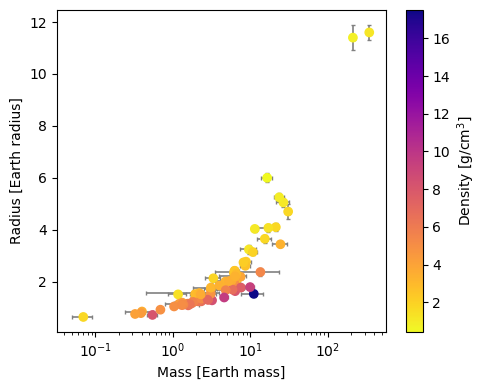

In [4]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(5,4))
plt.errorbar(M, R, xerr=err_M, yerr=err_R,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M, R, c=c, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Exoplaneteers made up cute names to describe planets in different compositions.
- "Rocky world" if a planet has a bulk density similar to the Earth.
- "Water world" if a planet has a bulk density consistent with 50% rocky and 50% water ice.
- "Puffy world" if a planet has a bulk density smaller than the "Water World" density.

Now, while it's possible that this final is making you wish you were on a "puff" of something or the other, we'll restrict our analysis to the rocky and water worlds. It's where the grant dollars are. 


### 3a - modeling the mass radius relation for rocky worlds (11 pts) 

First, select the rocky worlds. 

Let's write down the mass-radius relation for rocky worlds as a power law.

$R = aM^b$, where $a$ is proportional to $1/\rho_{\oplus}$, and $b$ is unitless. If the relation follows $M = \frac{4}{3}\pi R^3 \rho$, we have $a = 1$ and $b = 1/3$. However, in reality, the interior density of planets is not uniform and depends on the equation of state.

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

Hints:
- As a, b have to be positive, I'd suggest Uniform priors on log a, log b, and then using pm.Deterministic to exponentiate them 
- For the masses, since you've selected the rocky worlds, I'd suggest a normal distribution with the sample mean and sample standard deviation of the rocky worlds. 
- Given M, a, b you can use pm.Deterministic to get R_model
- Assume our favorite normal likelihood for R_model. You have the observed radius and their uncertainties from the file.

In [34]:
#select the rocky world
#Since rocky world is similar to the Earth, 
#we can use the cutout that rocky worlds have a density larger than 0.6*density of the Earth

rho_earth = 5.5
ind_rock = c > 0.6*rho_earth
c_rock = c[ind_rock]
M_rock = M[ind_rock]
R_rock = R[ind_rock]
err_R_rock = err_R[ind_rock]
err_M_rock = err_M[ind_rock]

In [17]:
#build the model

import pymc as pm
import numpy as np
with pm.Model() as hierarchical_model: 

    # Hyperpriors for group nodes
    loga = pm.Uniform('loga', lower = -2, upper = 2)
    logb = pm.Uniform('logb', lower = -2, upper = 2)
    
    
    a = pm.Deterministic('a', np.exp(loga))
    b = pm.Deterministic('b', np.exp(logb))
        
    R_model = pm.Deterministic('R_model',a*np.array(M_rock)**b)

    like = pm.Normal('likelihood', mu=R_model, sigma =np.array(err_R_rock), observed=np.array(R_rock))
    
    hm = pm.sample(2000, tune=500)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [loga, logb]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 15 seconds.


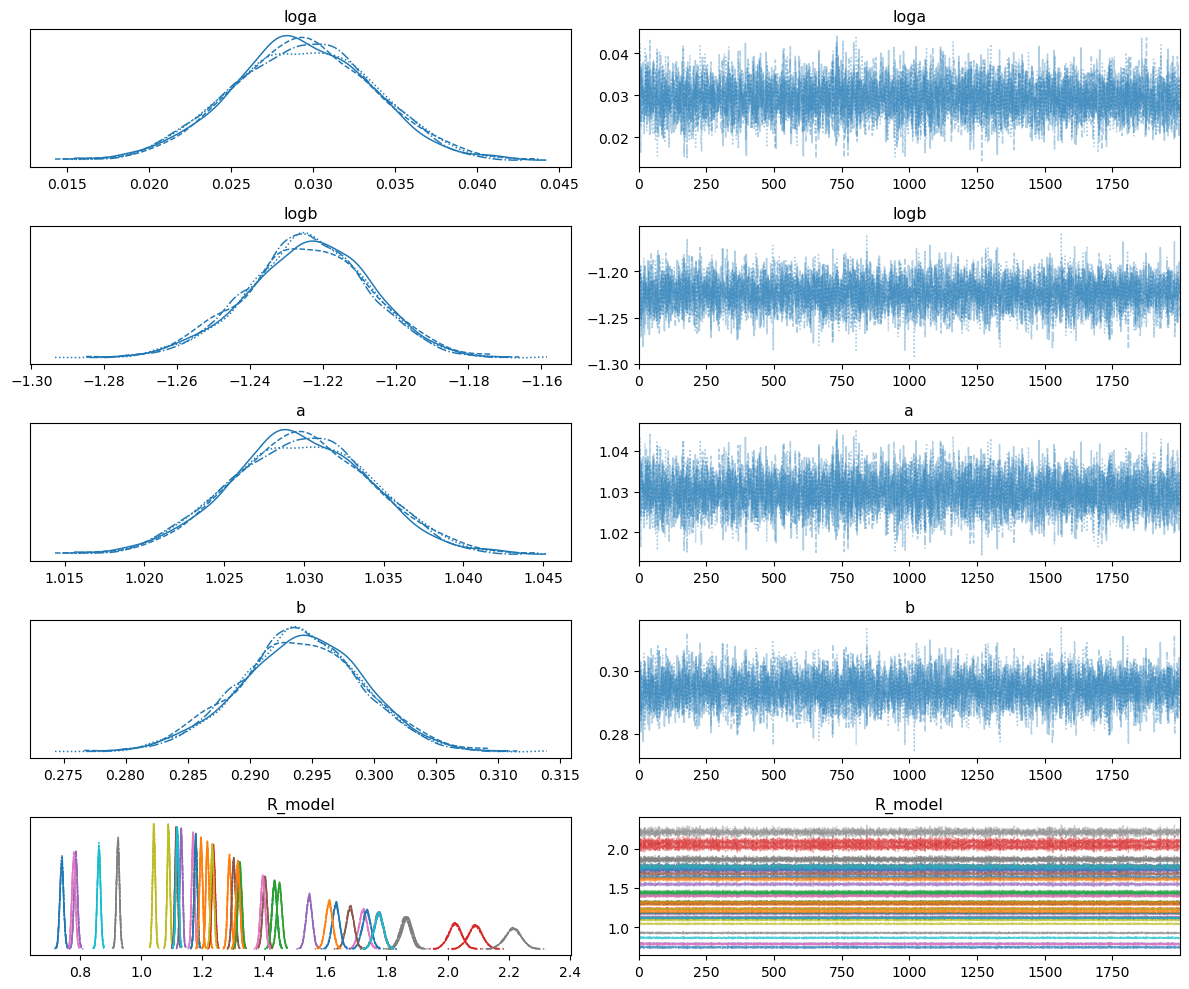

In [20]:
#plot the trace
pm.plot_trace(hm)
plt.tight_layout()

In [22]:
#find the best model
res_hm = pm.summary(hm)
a_best = res_hm['mean']['a']
b_best = res_hm['mean']['b']

In [76]:
#pull out some draws from the model
draws = [np.array(hm.posterior['a']).flatten(),np.array(hm.posterior['b']).flatten()]
draws = [np.array(draws[0])[::100],np.array(draws[1])[::100]]

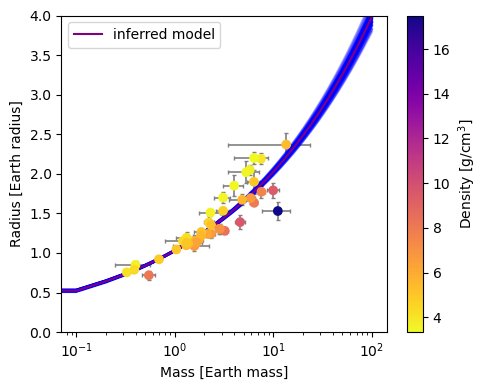

In [80]:
#plot the inferred model and some draws
x = np.linspace(0,100,1000)
plt.figure(figsize=(5,4))
plt.errorbar(M_rock, R_rock, xerr=err_M_rock, yerr=err_R_rock,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M_rock, R_rock, c=c_rock, zorder=100, cmap='plasma_r')
for i in range(len(draws[0])):
    plt.plot(x,draws[0][i]*x**draws[1][i],c = 'blue',alpha = 0.3)

plt.plot(x,a_best*x**b_best,c = 'purple',label = 'inferred model')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.ylim(0,4)
plt.tight_layout()
plt.legend()
plt.show()

### 3b - The Mass-Radius Relation for Rocky+Water Worlds (23 pts) 

Let's now add water worlds and model the mass-radius relation for both rocky and water worlds. Physically, it will require two models to describe the mass-radius relations for rocky and water worlds. The tricky part is we don't know exactly which kind of worlds a planet is belong to. In this situation, it is helpful to introduce a categorical variable `z` that is either 0 or 1, with the relative posterior probabilities telling us how Rocky/Watery a planet is.

Select the Rocky Water worlds - see the categories above 3a again. 

To make this work like magic with PyMC and it's Monte-Carlo sampler, we can choose a special prior for our categorial variable: the Drichlet Prior - https://en.wikipedia.org/wiki/Dirichlet_distribution

    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(RockyWaterWorlds))
    

The rest of the PyMC model should be the same as 3a except you are fitting two relations - one for rocky worlds and one for water worlds, so you need two different `a` and `b` parameters - `shape=2` as above should take it. You might want to sort the `a` parameter with `transform=pm.distributions.transforms.ordered` when you define the prior to sort things. 

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

In [162]:
#read in the data
rho_earth = 5.5
ind_rockwater = c > 0.5*0.6*rho_earth+0.5
c_rockwater = c[ind_rockwater]
M_rockwater = M[ind_rockwater]
R_rockwater = R[ind_rockwater]
err_R_rockwater = err_R[ind_rockwater]
err_M_rockwater = err_M[ind_rockwater]

In [164]:
#build the model
import pymc as pm
import numpy as np
with pm.Model() as hierarchical_model: 

    # Hyperpriors for group nodes
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(M_rockwater))
    #loga = pm.Uniform('loga', lower = -1, upper = 1, shape = 2)
    #logb = pm.Uniform('logb', lower = -2, upper = 1, shape = 2)
    
    
    a = pm.Uniform('a', lower = 0.2, upper = 2, shape = 2)
    b = pm.Uniform('b', lower = 0.1, upper = 1, shape = 2)
        
    R_model = pm.Deterministic('R_model',(z*a[0]*(np.array(M_rockwater)**b[0]))+(1-z)*a[1]*(np.array(M_rockwater)**b[1]))

    like = pm.Normal('likelihood', mu=R_model, sigma =np.array(err_R_rockwater), observed=np.array(R_rockwater))
    
    hm = pm.sample(2000, tune=500)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, a, b]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


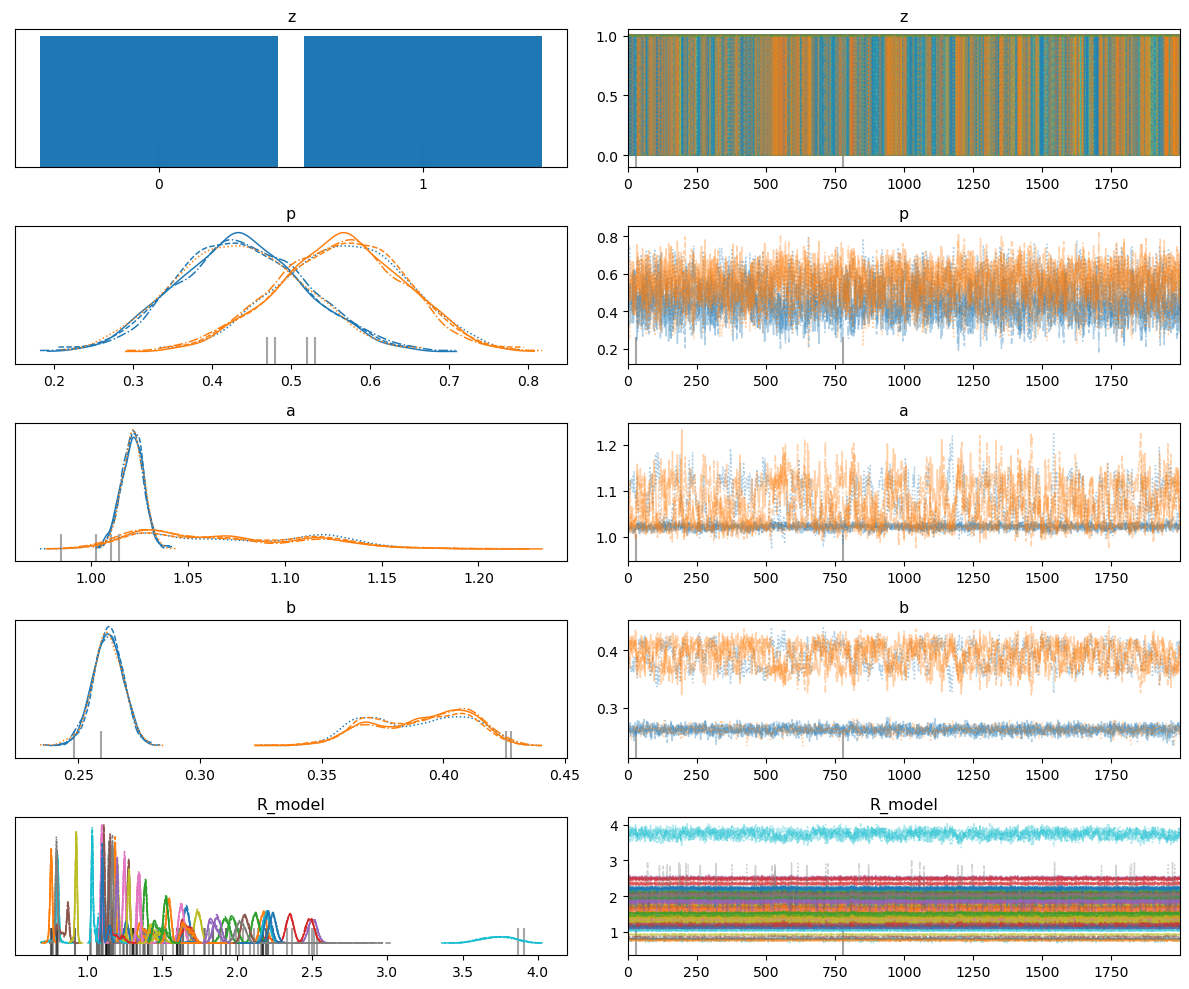

In [165]:
#plot the trace
pm.plot_trace(hm)
plt.tight_layout()

In [166]:
#get the best model
res_hm = pm.summary(hm)
a_best_0 = res_hm['mean']['a[0]']
a_best_1 = res_hm['mean']['a[1]']
b_best_0 = res_hm['mean']['b[0]']
b_best_1 = res_hm['mean']['b[1]']

In [169]:
#get the draws
draw_a0 = np.array(hm.posterior['a'][:,:,0]).flatten()[::200]
draw_a1 = np.array(hm.posterior['a'][:,:,1]).flatten()[::200]
draw_b0 = np.array(hm.posterior['b'][:,:,0]).flatten()[::200]
draw_b1 = np.array(hm.posterior['b'][:,:,1]).flatten()[::200]

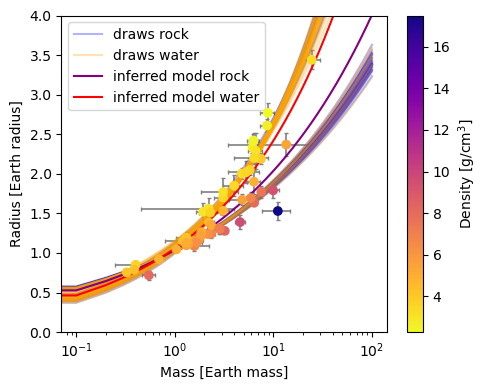

In [174]:
#plot
x = np.linspace(0,100,1000)
plt.figure(figsize=(5,4))
plt.errorbar(M_rockwater, R_rockwater, xerr=err_M_rockwater, yerr=err_R_rockwater,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M_rockwater, R_rockwater, c=c_rockwater, zorder=100, cmap='plasma_r')
for i in range(len(draw_a0)-1):
    plt.plot(x,draw_a0[i]*x**draw_b0[i],c = 'blue',alpha = 0.3)
    
plt.plot(x,draw_a0[len(draw_a0)-1]*x**draw_b0[len(draw_a0)-1],c = 'blue',alpha = 0.3,label = 'draws rock')

for i in range(len(draw_a1)-1):
    plt.plot(x,draw_a1[i]*x**draw_b1[i],c = 'orange',alpha = 0.3)

plt.plot(x,draw_a1[len(draw_a1)-1]*x**draw_b1[len(draw_a1)-1],c = 'orange',alpha = 0.3,label = 'draws water')

plt.plot(x,a_best_0*x**b_best_0,c = 'purple',label = 'inferred model rock')
plt.plot(x,a_best_1*x**b_best_1,c = 'red',label = 'inferred model water')

plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.ylim(0,4)
plt.xlim()
plt.tight_layout()
plt.legend()
plt.show()

### Throughout, make sure your plots have things like appropriate axes scales, axes labels, errorsbars, legends, reasonable colors. Remember, these are how you tell the story of what you've done, and ultimately what we're looking at.  


### Get started. You know how to do all of this. If not, there's something in a class notebook that can help. I'm on Teams, so direct questions there. 

# Best of luck. You've got this. 